In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
import scipy.stats
from astropy.visualization import hist
from tqdm.notebook import tqdm

plt.rcParams['figure.figsize'] = [5, 5]

%config InlineBackend.figure_format='retina'

In [2]:
from astroML.datasets import fetch_dr7_quasar

# Fetch the quasar data
data = fetch_dr7_quasar()

# select the first 10000 points
data = data[:10000]

z = data['redshift']

## Rejection sampling

In [3]:
# I create a step function that resembles the distribution of the data
# It's the same as using scipy.stats.rv_histogram((height, bins))

def step_f (x, step_h, step):
    f = np.zeros(np.size(x))
    for i in range(np.size(step)-1):    
        f = f + [step_h[i] if ((step[i]<k) and (step[i+1]>k)) else 0 for k in x]
    return f

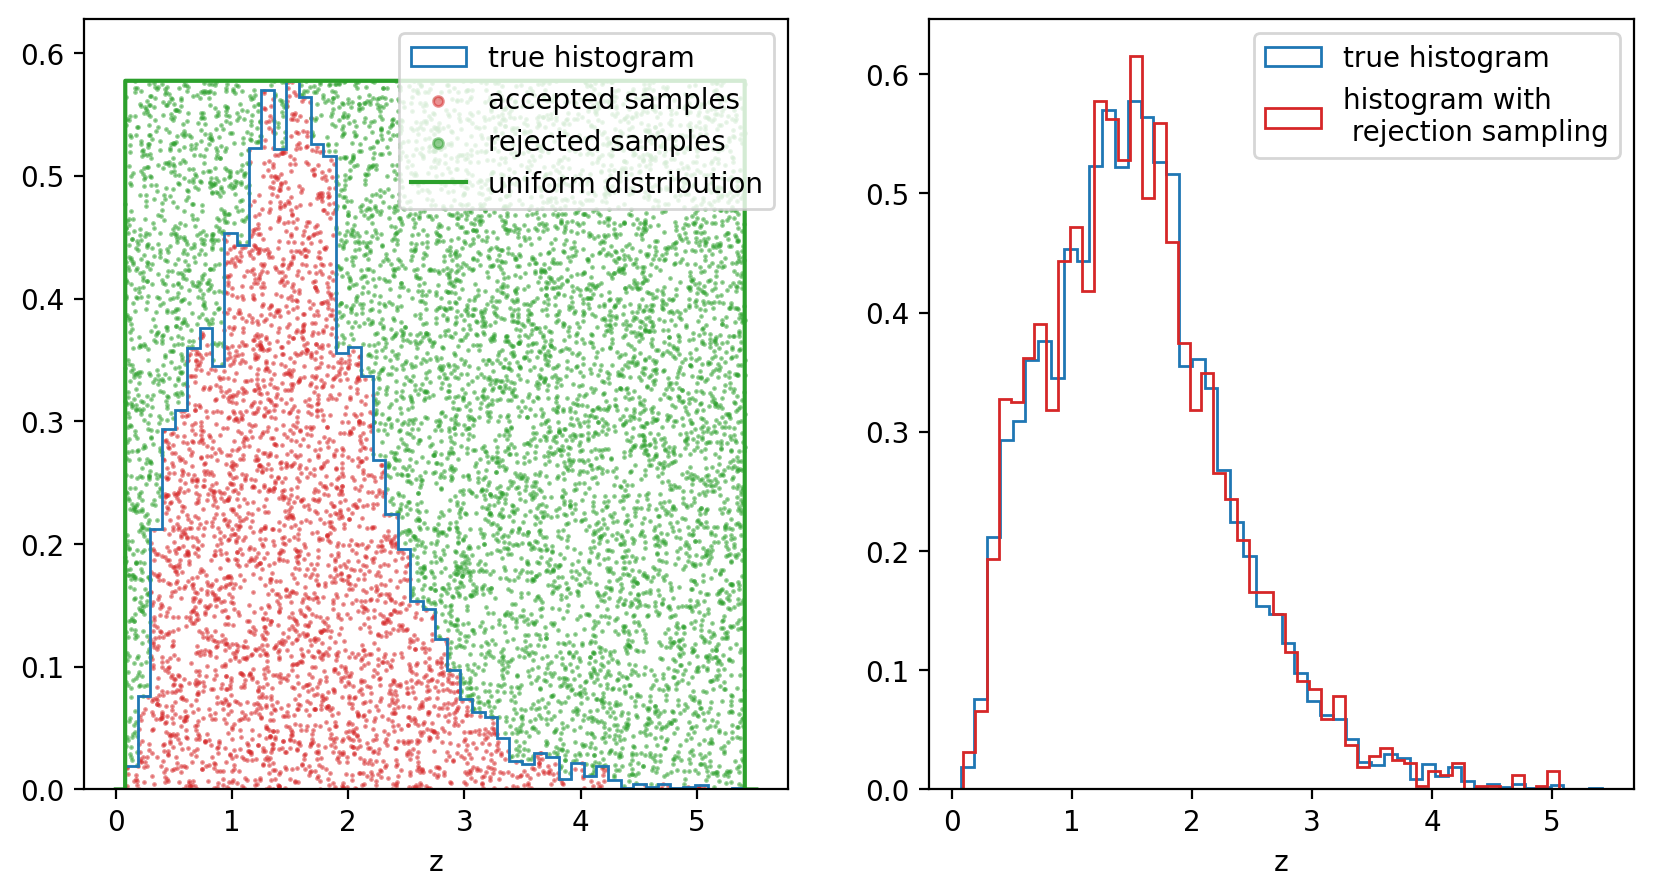

In [4]:
heights, bins = np.histogram(z, 50, density=True)

x = np.random.uniform(np.min(z), np.max(z), 10000)
y = np.random.uniform(0, np.max(heights), 10000)
f=step_f(x, heights, bins)

fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].hist(z, 50, density=True, histtype='step', color='tab:blue', label='true histogram')
axs[0].scatter(x[f>y], y[f>y], marker = '.', s=2, alpha=0.5, color='tab:red', label='accepted samples')
axs[0].scatter(x[f<y], y[f<y], marker = '.', s=2, alpha=0.5, color='tab:green', label='rejected samples')

#this is the uniform distribution
x_grid = np.linspace(0, max(z) + 0.1, 10000)
q = scipy.stats.uniform(min(z), max(z)-min(z)).pdf(x_grid)*(max(z)-min(z))*max(heights)
axs[0].set_ylim(0, np.max(heights) + 0.05)
axs[0].plot (x_grid, q, color='tab:green', label='uniform distribution')
axs[0].set_xlabel('z')
axs[0].legend(markerscale=5, loc='upper right')

good_x = x[f>y]

axs[1].hist(z, 50, histtype='step', density=True, color='tab:blue', label='true histogram')
axs[1].hist(good_x, 50, histtype='step', density=True, color='tab:red', label='histogram with \n rejection sampling')
axs[1].set_xlabel('z')
axs[1].legend()
plt.show()

## Inverse transform sampling

In [5]:
# Since we have an histogram for the distribution of data, it's possible to calculate the exact cumulative function.
# I evaluate this function over an array from the min(x) to max(x) (x is our variable z)
# Then I generate a random sample 𝑢 from a uniform random distribution [0,1],I find its closest value 
# from the cumulative function and I take the corresponding x
# Alternatively, since this method is really espensive, I could have interpolated the array (cumulative_f,x) 
# to find the quantile function

def cumulative_f(x, step_h, step):
    F = np.zeros(np.size(x))
    for i in range(np.size(x)):
        for j in range(np.size(step)-1):
            
            if (x[i]>=step[j+1]):
                F[i] = F[i] + step_h[j]*(step[j+1]-step[j])
                
            else:
                F[i] = F[i] + step_h[j]*(x[i]-step[j])
                break
    return F

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [6]:
xj = np.linspace(np.min(z), np.max(z), 3000)
u = np.linspace(0, 1, 3000)
best_idx = [find_nearest(cumulative_f(xj,heights,bins),k) for k in tqdm(u)]
best_x = xj[best_idx]

  0%|          | 0/3000 [00:00<?, ?it/s]

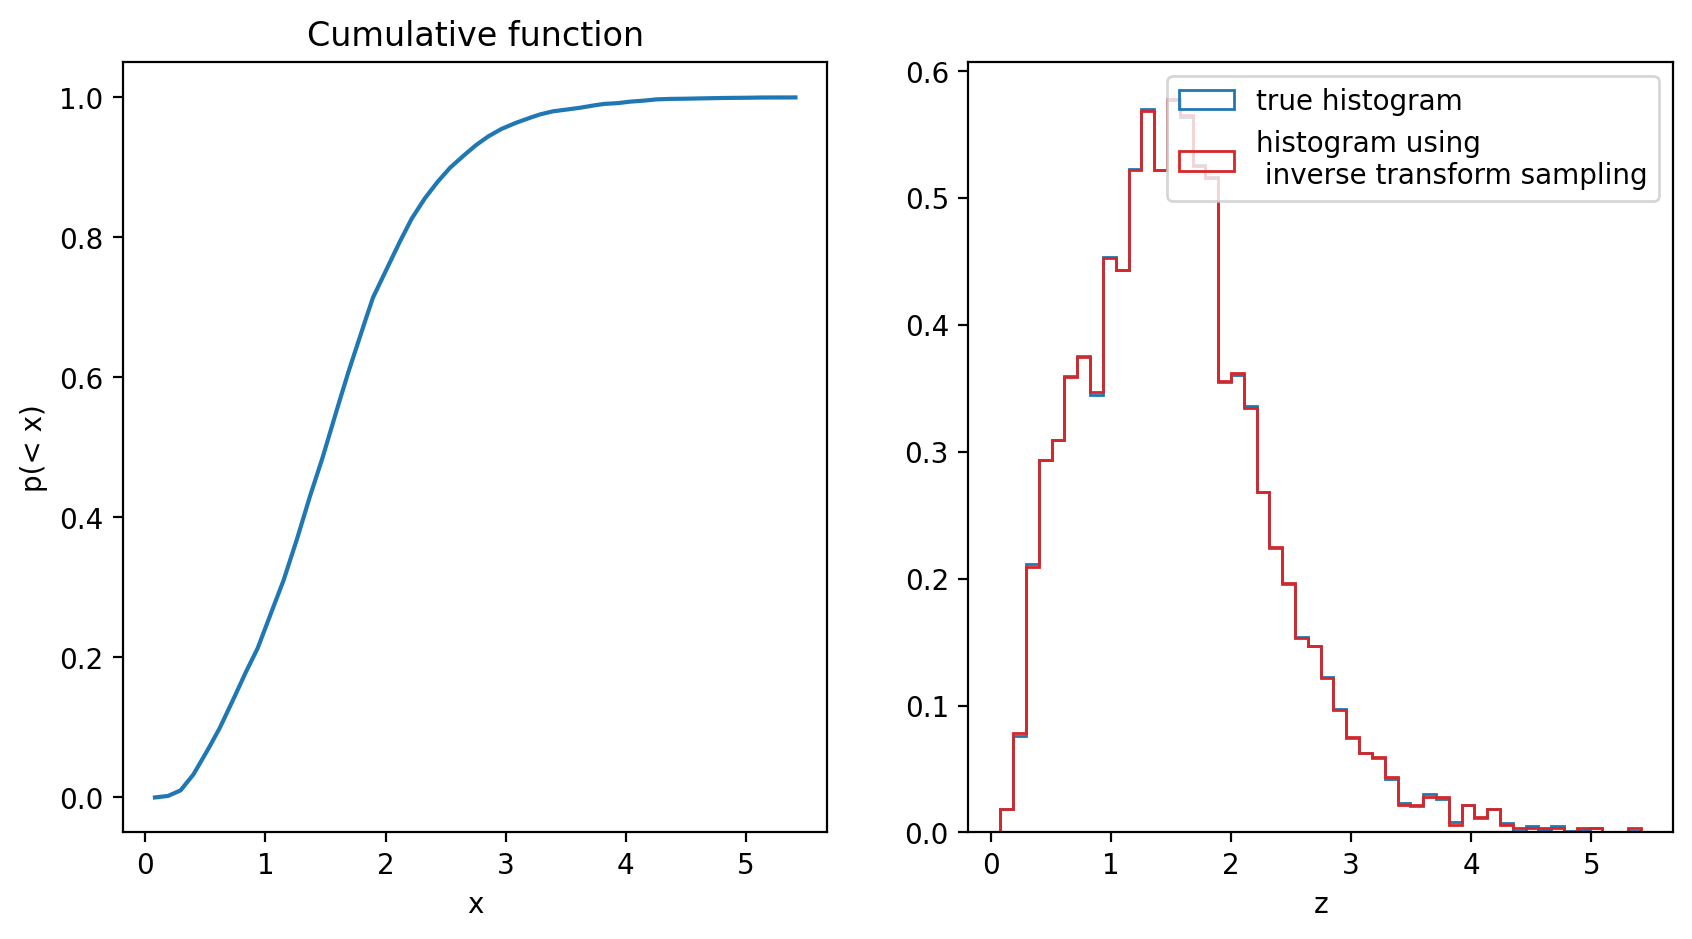

In [7]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

axs[0].plot(xj, cumulative_f(xj,heights,bins))
axs[0].set_title('Cumulative function')
axs[0].set_xlabel('x')
axs[0].set_ylabel('p(< x)')
axs[1].hist(z, 50, density=True, color='tab:blue', histtype='step', label='true histogram')
axs[1].hist(best_x, 50, density=True, color='tab:red', histtype='step', label='histogram using \n inverse transform sampling')
axs[1].set_xlabel('z')
axs[1].legend(loc='upper right')
plt.show()

## Empirical Distribution

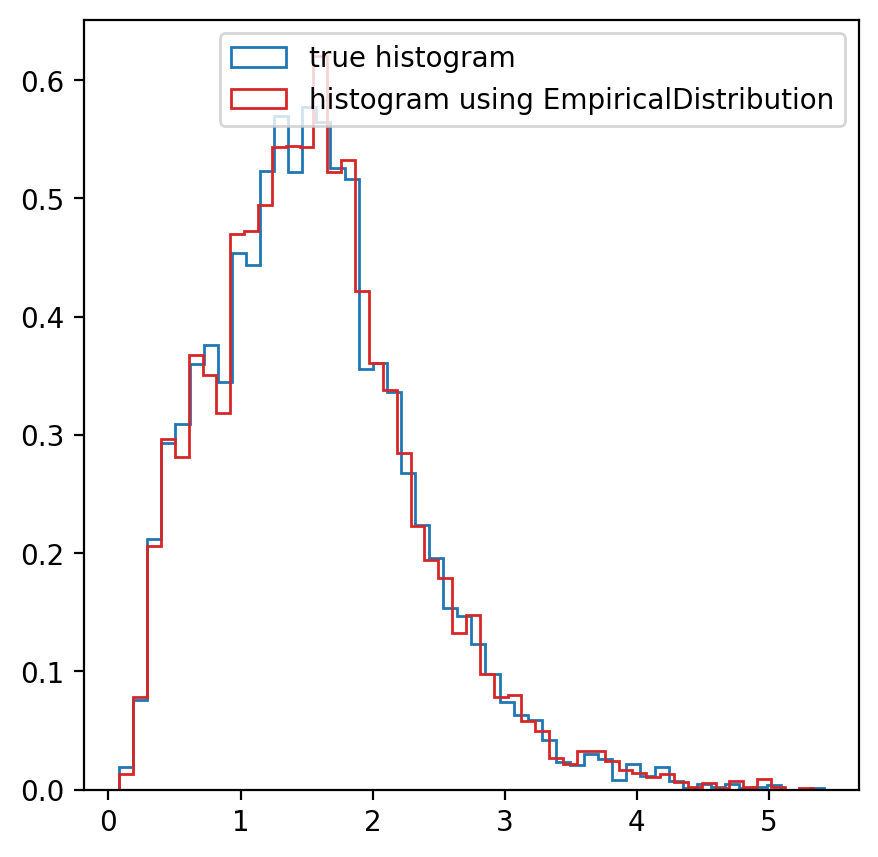

In [8]:
from astroML.density_estimation import EmpiricalDistribution
z_cloned = EmpiricalDistribution(z).rvs(10000)
plt.hist(z, 50, density=True, histtype='step', color='tab:blue', label='true histogram')
plt.hist(z_cloned, 50, density=True, histtype='step', color='tab:red', label='histogram using EmpiricalDistribution')
plt.legend()
plt.show()

## Cosmology

astropy.cosmology.Planck18.differential_comoving_volume(zgrid)

Differential comoving volume at redshift z.
Useful for calculating the effective comoving volume. For example, allows for integration over a comoving volume that has a sensitivity function that changes with redshift. The total comoving volume is given by integrating differential_comoving_volume to redshift z and multiplying by a solid angle.

In [9]:
import astropy
astropy.cosmology.Planck18

dV = lambda z : 4*np.pi*astropy.cosmology.Planck18.differential_comoving_volume(z).value

zgrid = np.linspace(0,5,100)
diffV = 4*np.pi*astropy.cosmology.Planck18.differential_comoving_volume(zgrid).value
V = scipy.integrate.quad(dV, 0, 5)[0]

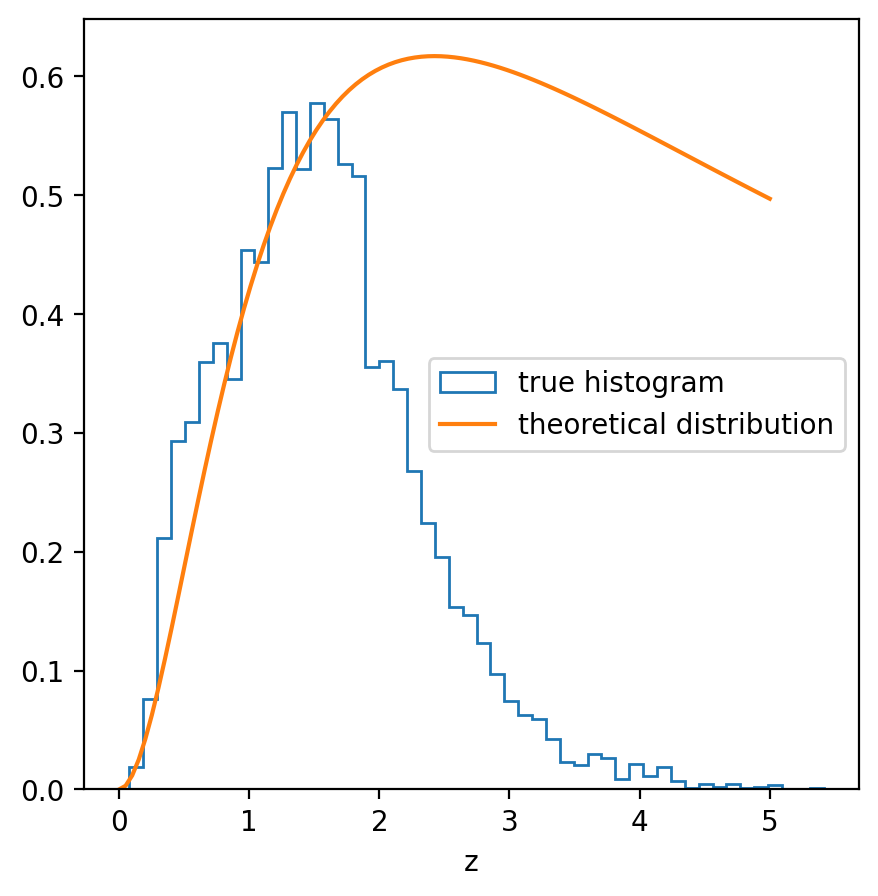

In [10]:
plt.hist(z, 50, density=True, histtype='step', label='true histogram')
plt.plot(zgrid,2.45*dV(zgrid)/V, label='theoretical distribution')
plt.xlabel('z')
plt.legend()
plt.show()